In [76]:
#Connecting to pgadmin

#Importing modules
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os

data_path = "."

def pgconnect(credential_filepath, db_schema="public"):
    # please replace <your_unikey> and <your_SID> with your own details in the credentials file!
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        HOST       = db_conn_dict['host']
        DB_USER    = db_conn_dict['user']
        DB_PW      = db_conn_dict['password']
        DEFAULT_DB = db_conn_dict['database']

        try:
            db = create_engine('postgres+psycopg2://'+DB_USER+':'+DB_PW+'@'+HOST+'/'+DEFAULT_DB, echo=False)
            conn = db.connect()
            print('connected')
        except Exception as e:
            print("unable to connect to the database")
            print(e)
        return db,conn

credfilepath = os.path.join(data_path, "data2x01_db.json")

In [56]:
#Login to database in pgadmin
db,conn = pgconnect(credfilepath)

connected


In [65]:
#Function required to load tables

def pgexecute( conn, sqlcmd, args=None, msg='', silent=False ):
    """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
    retval = False
    result_set = None

    try:
        if args is None:
            result_set = conn.execute(sqlcmd).fetchall()
        else:
            result_set = conn.execute(sqlcmd, args).fetchall()

        if silent == False: 
            print("success: " + msg)
            for record in result_set:
                print(record)
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval

def pgquery( conn, sqlcmd, args=None, silent=False ):
    """ utility function to execute some SQL query statement
    can take optional arguments to fill in (dictionary)
    will print out on screen the result set of the query
    error and transaction handling built-in """
    retdf = pd.DataFrame()
    retval = False
    try:
        if args is None:
            retdf = pd.read_sql_query(sqlcmd,conn)
        else:
            retdf = pd.read_sql_query(sqlcmd,conn,params=args)
        if silent == False:
            print(retdf.shape)
            print(retdf.to_string())
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval,retdf

In [75]:
#Importing modules for shp
from __future__ import (absolute_import, division, print_function)
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon

import geopandas as gpd
import seaborn as sns
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from sqlalchemy import create_engine

from sys import exit
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from shapely.geometry import Point, LineString
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy
import contextily as cx

RFS_path = "./ShapeRFS"
aust_path = "./ShapeAUST"

In [73]:
#Read RFS shp file
RFS_rows = gpd.read_file( os.path.join(RFS_path, "RFSNSW_BFPL_small.shp") )
print("#rows: ", len(RFS_rows))

#Renaming rows and creating gid
RFS_rows = RFS_rows.rename(columns={'CATEGORY':'category','SHAPE_LENG': 'shape_leng','SHAPE_AREA': 'shape_area'}, inplace = False)
gid_col = list(range(1, 45315))
RFS_rows.insert(loc=0, column='gid', value=gid_col)
RFS_rows.head()

#rows:  45314


,gid,category,shape_leng,shape_area,geometry
0,1,1,0.000890,4.949777e-08,POINT (149.83171 -34.29903)
1,2,1,0.008990,1.417500e-06,POINT (149.85673 -34.29558)
2,3,1,0.011250,1.775249e-06,POINT (149.84108 -34.29475)
3,4,1,0.001096,3.735098e-08,POINT (149.82560 -34.28852)
4,5,1,0.027890,6.131269e-06,POINT (149.74439 -34.26993)


In [165]:
def create_wkt_element(geom,srid):
    return WKTElement(geom.wkt, srid)

#Creating a copy and altering geom
srid=4283
rfs_copy = RFS_rows.copy()
rfs_copy['geom'] = RFS_rows['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))

#delete the old column before insert
rfs_copy = rfs_copy.drop(columns="geometry")
rfs_copy

,gid,category,shape_leng,shape_area,geom
0,1,1,0.000890,4.949777e-08,POINT (149.8317100010001 -34.29903349799994)
1,2,1,0.008990,1.417500e-06,POINT (149.8567335723469 -34.29557778521602)
2,3,1,0.011250,1.775249e-06,POINT (149.8410770166899 -34.29475165753482)
3,4,1,0.001096,3.735098e-08,POINT (149.8256000036667 -34.2885156663333)
4,5,1,0.027890,6.131269e-06,POINT (149.7443927481825 -34.26992535344596)
...,...,...,...,...,...
45309,45310,3,0.016425,1.036849e-05,POINT (151.4186292397088 -33.19950130069687)
45310,45311,3,0.012095,9.113554e-06,POINT (151.4048365639196 -33.19708743372861)
45311,45312,3,0.050685,8.878038e-05,POINT (151.3841253634019 -33.18942134322944)
45312,45313,1,0.080835,8.330816e-05,POINT (151.576883365202 -33.13407339961621)


In [166]:
#Creating Table for RFS
#Drop table if exists
conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")

rfs_schema = '''CREATE TABLE rfsnsw_bfpl (
                     gid        INTEGER PRIMARY KEY, 
                     category   NUMERIC NOT NULL,
                     shape_leng NUMERIC NOT NULL,
                     shape_area NUMERIC NOT NULL,
                     geom       GEOMETRY(POINT, 4283)
                     
               )'''
conn.execute(rfs_schema)

In [167]:
# Loding the data into table
table_name = 'rfsnsw_bfpl'
rfs_copy.to_sql(table_name, conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

In [7]:
#Reading SA2 shp file
aust_rows = gpd.read_file( os.path.join(aust_path, "SA2_2016_AUST.shp"))
print("#aust rows: ", len(aust_rows))

#Dropping NAs
attribute = aust_rows[ aust_rows['geometry'] == None].index
aust_rows.drop(attribute , inplace=True)
aust_rows.geom_type
aust_rows

#aust rows:  2310


,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,"POLYGON ((148.80406 -35.37620, 148.80416 -35.3..."
2304,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,"POLYGON ((105.67392 -10.41567, 105.67398 -10.4..."
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."


In [7]:
# Dropping duplicate rows
aust_rows.drop_duplicates(keep=False,inplace=True)
aust_rows

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,602031059,61059,George Town,60203,North East,602,Launceston and North East,6RTAS,Rest of Tas.,6,Tasmania,747.1680,"MULTIPOLYGON (((146.96639 -41.24155, 146.96616..."
2059,602031060,61060,Longford,60203,North East,602,Launceston and North East,6RTAS,Rest of Tas.,6,Tasmania,222.5428,"POLYGON ((147.02906 -41.58384, 147.03099 -41.5..."
2060,602031061,61061,Northern Midlands,60203,North East,602,Launceston and North East,6RTAS,Rest of Tas.,6,Tasmania,4763.6291,"POLYGON ((147.11826 -41.93730, 147.11269 -41.9..."
2061,602031062,61062,Perth - Evandale,60203,North East,602,Launceston and North East,6RTAS,Rest of Tas.,6,Tasmania,226.7697,"POLYGON ((147.15820 -41.57707, 147.14529 -41.5..."


In [74]:
#Renaming column names 
aust_rows.rename(columns={'SA2_MAIN16':'sa2_main16' ,'SA2_5DIG16':'sa2_5dig16' ,'SA2_NAME16':'sa2_name16', 'SA3_CODE16':'sa3_code', 'SA3_NAME16':'sa3_name', 'SA4_CODE16':'sa4_code', 'SA4_NAME16':'sa4_name', 'GCC_CODE16':'gcc_code', 'GCC_NAME16':'gcc_name','STE_CODE16':'ste_code','STE_NAME16':'ste_name','AREASQKM16':'areasqkm16' }, inplace = True)

#Creating gid
gid_col = list(range(1, 2293))
aust_rows.insert(loc=0, column='g_id', value=gid_col)
aust_rows.head()

In [171]:
#Creating Table for AUST
#Drop table if exists
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")

aust_schema = '''CREATE TABLE sa2_2016_aust (
                     g_id         INTEGER , 
                     sa2_main16   INTEGER PRIMARY KEY, 
                     sa2_5dig16   NUMERIC NOT NULL,
                     sa2_name16   VARCHAR(150) NOT NULL,
                     sa3_code     NUMERIC NOT NULL,
                     sa3_name     VARCHAR(150) NOT NULL,
                     sa4_code     NUMERIC NOT NULL,
                     sa4_name     VARCHAR(150) NOT NULL,
                     gcc_code     VARCHAR(40) NOT NULL,
                     gcc_name     VARCHAR(150) NOT NULL,
                     ste_code     NUMERIC NOT NULL,
                     ste_name     VARCHAR(150) NOT NULL,
                     areasqkm16   NUMERIC NOT NULL,
                     geom         GEOMETRY(MULTIPOLYGON,4283)
                                         
               )'''
conn.execute(aust_schema)

In [51]:
def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
        return WKTElement(geom.wkt, srid)
    
srid = 4283

# since we are altering data again, we should create another copy
aust_copy = aust_rows.copy()
aust_copy['geom'] = aust_rows['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))

#delete the old column before insert
aust_copy = aust_copy.drop(columns="geometry")
aust_copy

,g_id,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geom
0,1,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,MULTIPOLYGON (((149.5842329970001 -35.44426999...
1,2,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,MULTIPOLYGON (((149.2189819130001 -35.36739402...
2,3,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,MULTIPOLYGON (((149.2132479820001 -35.34324799...
3,4,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,MULTIPOLYGON (((149.240332114 -35.347822616999...
4,5,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,MULTIPOLYGON (((149.235800967 -35.387375302999...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,2288,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,MULTIPOLYGON (((148.804064002 -35.376204003999...
2304,2289,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,MULTIPOLYGON (((105.6739190100001 -10.41567300...
2305,2290,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,None
2306,2291,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,None


In [75]:
#Loading data into table
aust_table_name = "sa2_2016_aust"
aust_copy.to_sql(aust_table_name, conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [181]:
#Loading the csv files
#Staistical Areas
stat_areas = pd.read_csv('StatisticalAreas.csv', thousands =",")
stat_areas.drop_duplicates(subset="area_id",keep=False,inplace=True)

#Neighbourhoods
n_hoods = pd.read_csv('Neighbourhoods.csv', thousands =",")
n_hoods.rename(columns={'number_of_dwellings':'dwellings','number_of_businesses':'businesses','median_annual_household_income':'median_income'}, inplace = True)
n_hoods.drop(n_hoods.loc[n_hoods['population'].isna()].index, inplace=True)
n_hoods.drop(n_hoods.loc[n_hoods['dwellings'].isna()].index, inplace=True )
n_hoods.drop(n_hoods.loc[n_hoods['median_income'].isna()].index, inplace=True )
n_hoods.drop(n_hoods.loc[n_hoods['avg_monthly_rent'].isna()].index, inplace=True )
# n_hoods.dropna()

#Business Statistics
buss_stats = pd.read_csv('BusinessStats.csv', thousands =",") 
buss_stats.rename(columns={'accommodation_and_food_services':'accommodation_and_food'}, inplace = True)
buss_stats.drop(buss_stats.loc[buss_stats['number_of_businesses'].isna()].index, inplace=True )
buss_stats.drop(buss_stats.loc[buss_stats['health_care_and_social_assistance'].isna()].index, inplace=True )

n_hoods

,area_id,area_name,land_area,population,dwellings,businesses,median_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,2325,738.0,46996.0,1906.0
1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,3847,907.0,42621.0,1682.0
2,102011030,Calga - Kulnura,76795.1000,4841.0,1575,1102.0,42105.0,1182.0
3,102011031,Erina - Green Point,3379.3000,14237.0,4450,1666.0,43481.0,1595.0
4,102011032,Gosford - Springfield,1691.2000,19385.0,6373,2126.0,45972.0,1382.0
...,...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931.0,3281,673.0,73164.0,1080.0
318,106011113,Singleton Region,4067.2349,4919.0,2055,698.0,87984.0,1000.0
319,111021218,Morisset - Cooranbong,330.5208,14959.0,6298,1154.0,58084.0,1260.0
320,114021285,Hill Top - Colo Vale,174.3752,6025.0,2249,400.0,81120.0,1512.0


In [76]:
# Dropping tables if they exist
conn.execute("DROP TABLE IF EXISTS statisticalareas, neighbourhoods, businessstats", conn)

In [183]:
#Creating our database table 

#Statistical Areas
stat_schema = """CREATE TABLE IF NOT EXISTS statisticalareas (
                         area_id         INTEGER PRIMARY KEY,
                         area_name       VARCHAR(150) NOT NULL,
                         parent_area_id  INTEGER NOT NULL
                   )"""
conn.execute(stat_schema)

#Neighbourhoods
n_schema = """CREATE TABLE IF NOT EXISTS neighbourhoods(
                         area_id                         INTEGER PRIMARY KEY,
                         area_name                       VARCHAR(150) NOT NULL,
                         land_area                       FLOAT NOT NULL,
                         population                      INTEGER NOT NULL,
                         dwellings                       INTEGER NOT NULL,
                         businesses                      INTEGER NOT NULL,
                         median_income                   INTEGER NOT NULL,
                         avg_monthly_rent                INTEGER NOT NULL
    
                )"""
conn.execute(n_schema)

#Business Stats
buss_schema = """CREATE TABLE IF NOT EXISTS businessstats (
                         area_id                           INTEGER PRIMARY KEY,
                         area_name                         VARCHAR(150) NOT NULL,
                         number_of_businesses              INTEGER NOT NULL,
                         accommodation_and_food            INTEGER NOT NULL,
                         retail_trade                      INTEGER NOT NULL,
                         agriculture_forestry_and_fishing  INTEGER NOT NULL,
                         health_care_and_social_assistance INTEGER NOT NULL,
                         public_administration_and_safety  INTEGER NOT NULL,
                         transport_postal_and_warehousing  INTEGER NOT NULL
                )"""

conn.execute(buss_schema)
print(db.table_names())

['spatial_ref_sys', 'risk_score', 'rfsnsw_bfpl', 'sa2_2016_aust', 'statisticalareas', 'neighbourhoods', 'businessstats', 'joined_shape', 'joined_all', 'joined_csv', 'exten', 'all_values', 'all_density', 'avg_stdev', 'all_col', 'z_score']


In [184]:
#Load the data into the table

#Statistical Areas
table_name1 = "statisticalareas"
stat_areas.to_sql(table_name1, con=conn, if_exists='append',index=False)

#Neighbourhoods
table_name2 = "neighbourhoods"
n_hoods.to_sql(table_name2, con=conn, if_exists='append',index=False)

#Business Stats
table_name3 = "businessstats"
buss_stats.to_sql(table_name3, con=conn, if_exists='append',index=False)


In [ ]:
# Note while running below queries:
# Upon running the cell, the first query will retun resource closed error.
# The query is executed, as it does not return anything it gives the error.
# To execute the next query, comment the previous query and re run the cell again.

In [77]:
#Adding primary and foreign keys to the table
pd.read_sql_query("ALTER TABLE statisticalareas ADD PRIMARY KEY(area_id) ", conn)
pd.read_sql_query("ALTER TABLE businessstats ADD PRIMARY KEY(area_id) ", conn)
pd.read_sql_query("ALTER TABLE neighbourhoods ADD PRIMARY KEY(area_id) ", conn)
pd.read_sql_query("ALTER TABLE neighbourhoods ADD CONSTRAINT fk FOREIGN KEY(area_id) REFERENCES sa2_2016_aust(sa2_main16)", conn)


In [78]:
#Creating Indexes for CSV files
pd.read_sql_query("CREATE INDEX s_area_id ON statisticalareas(area_id)",conn)
pd.read_sql_query("CREATE INDEX n_area_id ON neighbourhoods(area_id)",conn)
pd.read_sql_query("CREATE INDEX b_area_id ON businessstats(area_id)",conn)

In [9]:
#Creating joined CSV file
pd.read_sql_query("DROP TABLE IF EXISTS joined_csv", conn)
pd.read_sql_query("CREATE TABLE joined_csv AS SELECT * FROM statisticalareas NATURAL JOIN (SELECT * FROM neighbourhoods NATURAL JOIN businessstats) AS s", conn)
pd.read_sql_query("SELECT * FROM joined_csv", conn)

,area_id,area_name,parent_area_id,land_area,population,dwellings,businesses,median_income,avg_monthly_rent,number_of_businesses,accommodation_and_food,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,102011028,Avoca Beach - Copacabana,10201,643.8000,7590,2325,738,46996,1906,724,33,35,4,60,0,19
1,102011029,Box Head - MacMasters Beach,10201,3208.6000,10986,3847,907,42621,1682,934,23,45,13,43,3,28
2,102011030,Calga - Kulnura,10201,76795.1000,4841,1575,1102,42105,1182,1134,14,43,231,12,0,55
3,102011031,Erina - Green Point,10201,3379.3000,14237,4450,1666,43481,1595,1712,68,145,19,179,12,43
4,102011032,Gosford - Springfield,10201,1691.2000,19385,6373,2126,45972,1382,2233,94,167,9,246,10,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,106011109,Cessnock Region,10601,1570.4341,7931,3281,673,73164,1080,673,21,32,136,16,3,42
305,106011113,Singleton Region,10601,4067.2349,4919,2055,698,87984,1000,698,13,11,334,10,0,27
306,111021218,Morisset - Cooranbong,11102,330.5208,14959,6298,1154,58084,1260,1154,31,73,45,68,4,82
307,114021285,Hill Top - Colo Vale,11402,174.3752,6025,2249,400,81120,1512,400,12,20,27,13,0,54


In [79]:
#Creating Indexes for shp files
pd.read_sql_query("CREATE INDEX rfs_geom ON rfsnsw_bfpl USING GIST(geom)", conn)
pd.read_sql_query("CREATE INDEX sa2_geom ON sa2_2016_aust USING GIST(geom)", conn)

In [12]:
# Joining shape files
pd.read_sql_query("DROP TABLE IF EXISTS joined_shape", conn)
pd.read_sql_query("CREATE TABLE joined_shape AS SELECT sa2_main16, SUM(shape_area) as shape_area, SUM(shape_leng) as shape_leng, sa2_2016_aust.geom as multipolygon_geom , sa2_5dig16, sa2_name16, sa3_code, sa3_name, sa4_code, sa4_name, gcc_code, gcc_name, ste_code, ste_name, areasqkm16, category FROM rfsnsw_bfpl JOIN sa2_2016_aust ON (ST_Contains(sa2_2016_aust.geom, rfsnsw_bfpl.geom)) GROUP BY sa2_main16, sa2_5dig16, sa2_name16, sa3_code, sa3_name, sa4_code, sa4_name, gcc_code, gcc_name, ste_code, ste_name, areasqkm16, category", conn)
pd.read_sql_query("SELECT * FROM joined_shape", conn)

,count
0,43765


In [14]:
# Own dataset
# We are finding the number of veteniaries at each neighbourhood.

# Get the neighbourhoods names - for Own Dataset(MAP API)
import re

names = pd.read_sql_query("SELECT area_name FROM joined_csv", conn)
names

places = []

# Formatting the area names to enable consistent searches
for n in names.area_name:
    ls = n.split()
    
    if len(ls) > 1 :
        if ls[1] != "-" and re.search(ls[1], "(NSW)") == None:
            text = ls[0] + " " + ls[1]
            places.append(text)
        else:
            places.append(ls[0])     
    else:
        places.append(ls[0])
print(len(names.area_name))

for n in places:
    print(n)

309
Avoca Beach
Box Head
Calga
Erina
Gosford
Kariong
Kincumber
Narara
Niagara Park
Point Clare
Saratoga
Terrigal
Umina
Wamberal
Woy Woy
Wyoming
Bateau Bay
Blue Haven
Budgewoi
Chittaway Bay
Gorokan
Jilliby
Lake Munmorah
Ourimbah
Summerland Point
The Entrance
Toukley
Tuggerah
Warnervale
Wyong
Baulkham Hills
Baulkham Hills
Glenhaven
West Pennant
Castle Hill
Castle Hill
Castle Hill
Castle Hill
Castle Hill
Cherrybrook
Kellyville
Dural
Galston
Bilpin
Kurrajong Heights
Pitt Town
Rouse Hill
Blacktown (East)
Blacktown (North)
Doonside
Lalor Park
Seven Hills
Blacktown (South)
Blacktown (West)
Glenwood
Parklea
Riverstone
Acacia Gardens
Quakers Hill
Bidwill
Glendenning
Hassall Grove
Lethbridge Park
Mount Druitt
Rooty Hill
Botany
Mascot
Pagewood
Marrickville
Petersham
Sydenham
Darlinghurst
Erskineville
Glebe
Newtown
Potts Point
Pyrmont
Redfern
Surry Hills
Sydney
Waterloo
Bondi
Bondi Beach
Bondi Junction
Double Bay
Dover Heights
Paddington
Rose Bay
Woollahra
Coogee
Malabar
Kensington
Kingsford
Marou

In [15]:
# Lookup of a given address via Open Street Maps Wep-API:
import requests
import time
import random
import pprint

def waitrequest(base_url, my_params):
    # wait 5 second before we make the request, ideally we can prevent too many requests this way 
    # if we do too many requests, the whole uni's IP range can be locked out!
    classsize = 25
    sleeptime = random.randint(1,classsize)
    print("waiting for "+str(sleeptime)+" seconds based on a class size of "+str(classsize))
    time.sleep(sleeptime)
    return requests.get(base_url, params = my_params)

In [16]:
# Finding the number of veteniaries in each neighbourhood.

i = 0
vet = []
while i < len(places):
    count = 0;
    
    # The string to be searched.
    param = "Veterinary " + str(places[i]) + " NSW Australia"
    
    base_url = 'https://nominatim.openstreetmap.org/search'
    my_params= {'q': param ,'format':'json'}

    response = waitrequest(base_url, my_params)
    results  = response
    
    if (results):
        print("This is what the response looks like:")
        print(results.text)
        
        # Findng the number of results found
        if len(results.text) == 2:
            # As we are converting the result to text, empty list [] is counted as two characters.
            vet.append(0)
            
        else:
            # As we are converting the result to text, non-empty result is stored in a pair of curly braces {} each.
            num = results.text.count('{')
            vet.append(num)
    else:
        print("no results")
    i+=1

    # Printing the list of number of veteniaries found.
for i in vet:
    print(i)

waiting for 15 seconds based on a class size of 25
This is what the response looks like:
[]
waiting for 8 seconds based on a class size of 25
This is what the response looks like:
[]
waiting for 16 seconds based on a class size of 25
This is what the response looks like:
[]
waiting for 17 seconds based on a class size of 25
This is what the response looks like:
[]
waiting for 17 seconds based on a class size of 25
This is what the response looks like:
[{"place_id":209743044,"licence":"Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright","osm_type":"way","osm_id":561259727,"boundingbox":["-33.4465516","-33.4464206","151.3274422","151.3277244"],"lat":"-33.44648","lon":"151.32757827585127","display_name":"Point Clare Veterinary Hospital, 45, Brisbane Water Drive, Point Clare, Gosford, Central Coast Council, New South Wales, 2250, Australia","class":"amenity","type":"veterinary","importance":0.32100000000000006},{"place_id":198525274,"licence":"Data © OpenStreetMap contr

In [22]:
#Adding vets column long with joined_csv and creating new table
res = pd.read_sql_query("SELECT * FROM joined_csv", conn)
res.insert(loc=16, column='vets', value=vet)
res

,area_id,area_name,parent_area_id,land_area,population,dwellings,businesses,median_income,avg_monthly_rent,number_of_businesses,accommodation_and_food,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,vets
0,102011028,Avoca Beach - Copacabana,10201,643.8000,7590,2325,738,46996,1906,724,33,35,4,60,0,19,0
1,102011029,Box Head - MacMasters Beach,10201,3208.6000,10986,3847,907,42621,1682,934,23,45,13,43,3,28,0
2,102011030,Calga - Kulnura,10201,76795.1000,4841,1575,1102,42105,1182,1134,14,43,231,12,0,55,0
3,102011031,Erina - Green Point,10201,3379.3000,14237,4450,1666,43481,1595,1712,68,145,19,179,12,43,0
4,102011032,Gosford - Springfield,10201,1691.2000,19385,6373,2126,45972,1382,2233,94,167,9,246,10,97,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,106011109,Cessnock Region,10601,1570.4341,7931,3281,673,73164,1080,673,21,32,136,16,3,42,0
305,106011113,Singleton Region,10601,4067.2349,4919,2055,698,87984,1000,698,13,11,334,10,0,27,0
306,111021218,Morisset - Cooranbong,11102,330.5208,14959,6298,1154,58084,1260,1154,31,73,45,68,4,82,0
307,114021285,Hill Top - Colo Vale,11402,174.3752,6025,2249,400,81120,1512,400,12,20,27,13,0,54,10


In [23]:
# creating a table that stores the extension column as well.
conn.execute("DROP TABLE IF EXISTS exten")

exten_schema = """CREATE TABLE IF NOT EXISTS exten (
                         area_id                           INTEGER PRIMARY KEY,
                         area_name                         VARCHAR(150),
                         parent_area_id                    INTEGER,
                         land_area                         FLOAT,
                         population                        INTEGER,
                         dwellings                         INTEGER,
                         businesses                        INTEGER,
                         median_income                     INTEGER,
                         avg_monthly_rent                  INTEGER,
                         number_of_businesses              INTEGER,
                         accommodation_and_food            INTEGER,
                         retail_trade                      INTEGER,
                         agriculture_forestry_and_fishing  INTEGER,
                         health_care_and_social_assistance INTEGER,
                         public_administration_and_safety  INTEGER,
                         transport_postal_and_warehousing  INTEGER,
                         vets                              INTEGER
                   )"""
conn.execute(exten_schema)

table_name = "exten"
res.to_sql(table_name, con=conn, if_exists='append',index=False)
pd.read_sql_query("SELECT * FROM exten", conn)

,area_id,area_name,parent_area_id,land_area,population,dwellings,businesses,median_income,avg_monthly_rent,number_of_businesses,accommodation_and_food,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,vets
0,102011028,Avoca Beach - Copacabana,10201,643.8000,7590,2325,738,46996,1906,724,33,35,4,60,0,19,0
1,102011029,Box Head - MacMasters Beach,10201,3208.6000,10986,3847,907,42621,1682,934,23,45,13,43,3,28,0
2,102011030,Calga - Kulnura,10201,76795.1000,4841,1575,1102,42105,1182,1134,14,43,231,12,0,55,0
3,102011031,Erina - Green Point,10201,3379.3000,14237,4450,1666,43481,1595,1712,68,145,19,179,12,43,0
4,102011032,Gosford - Springfield,10201,1691.2000,19385,6373,2126,45972,1382,2233,94,167,9,246,10,97,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,106011109,Cessnock Region,10601,1570.4341,7931,3281,673,73164,1080,673,21,32,136,16,3,42,0
305,106011113,Singleton Region,10601,4067.2349,4919,2055,698,87984,1000,698,13,11,334,10,0,27,0
306,111021218,Morisset - Cooranbong,11102,330.5208,14959,6298,1154,58084,1260,1154,31,73,45,68,4,82,0
307,114021285,Hill Top - Colo Vale,11402,174.3752,6025,2249,400,81120,1512,400,12,20,27,13,0,54,10


In [73]:
#Indexes for joined_shp and joined_csv
pd.read_sql_query("CREATE INDEX sa2_main ON joined_shape(sa2_main16)", conn)
pd.read_sql_query("CREATE INDEX csv_area_id ON exten(area_id)", conn)

In [27]:
#Joining all tables
pd.read_sql_query("DROP TABLE IF EXISTS joined_all", conn)
pd.read_sql_query("CREATE TABLE joined_all AS SELECT * FROM joined_shape, exten WHERE CAST(joined_shape.sa2_main16 as INTEGER) = exten.area_id ", conn)
pd.read_sql_query("SELECT * FROM joined_all", conn)

,sa2_main16,shape_area,shape_leng,multipolygon_geom,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,...,median_income,avg_monthly_rent,number_of_businesses,accommodation_and_food,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,vets
0,101051540,3.552184e-01,190.182540,0106000020BB10000001000000010300000002000000C0...,11540.0,Goulburn Region,10105.0,Goulburn - Mulwaree,101.0,Capital Region,...,62712,800,1891,38,52,1041,33,3,81,0
1,101051540,1.647674e-02,21.333755,0106000020BB10000001000000010300000002000000C0...,11540.0,Goulburn Region,10105.0,Goulburn - Mulwaree,101.0,Capital Region,...,62712,800,1891,38,52,1041,33,3,81,0
2,101051540,2.949808e-02,14.280367,0106000020BB10000001000000010300000002000000C0...,11540.0,Goulburn Region,10105.0,Goulburn - Mulwaree,101.0,Capital Region,...,62712,800,1891,38,52,1041,33,3,81,0
3,102011028,8.370119e-05,0.209594,0106000020BB100000010000000103000000010000005E...,11028.0,Avoca Beach - Copacabana,10201.0,Gosford,102.0,Central Coast,...,46996,1906,724,33,35,4,60,0,19,0
4,102011028,1.487605e-05,0.097726,0106000020BB100000010000000103000000010000005E...,11028.0,Avoca Beach - Copacabana,10201.0,Gosford,102.0,Central Coast,...,46996,1906,724,33,35,4,60,0,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,128021607,3.349484e-07,0.003456,0106000020BB100000010000000103000000010000008E...,11607.0,Engadine,12802.0,Sutherland - Menai - Heathcote,128.0,Sydney - Sutherland,...,52667,1955,1106,37,69,3,82,9,51,0
379,128021608,3.851032e-06,0.019936,0106000020BB10000001000000010300000001000000A1...,11608.0,Loftus - Yarrawarrah,12802.0,Sutherland - Menai - Heathcote,128.0,Sydney - Sutherland,...,51243,2163,452,9,20,3,25,5,31,0
380,128021608,4.077420e-06,0.025266,0106000020BB10000001000000010300000001000000A1...,11608.0,Loftus - Yarrawarrah,12802.0,Sutherland - Menai - Heathcote,128.0,Sydney - Sutherland,...,51243,2163,452,9,20,3,25,5,31,0
381,128021609,8.862428e-03,7.121421,0106000020BB10000001000000010300000001000000F0...,11609.0,Woronora Heights,12802.0,Sutherland - Menai - Heathcote,128.0,Sydney - Sutherland,...,54935,2300,265,4,12,0,11,0,14,0


In [72]:
#Creating indexes for joined_all

pd.read_sql_query("CREATE INDEX n_land_area ON joined_all(land_area)", conn)
pd.read_sql_query("CREATE INDEX n_population ON joined_all(population)", conn)
pd.read_sql_query("CREATE INDEX n_dwellings ON joined_all(dwellings)", conn)
pd.read_sql_query("CREATE INDEX n_median_income ON joined_all(median_income)", conn)
pd.read_sql_query("CREATE INDEX n_monthly_rent ON joined_all(avg_monthly_rent)",conn)
pd.read_sql_query("CREATE INDEX n_businesses ON joined_all(number_of_businesses)",conn)
pd.read_sql_query("CREATE INDEX n_category ON joined_all(category)",conn)
pd.read_sql_query("CREATE INDEX n_vets ON joined_all(vets)",conn)
pd.read_sql_query("CREATE INDEX n_health_assis ON joined_all(health_care_and_social_assistance)",conn)


In [40]:
#Calculating all densities
# pd.read_sql_query("DROP TABLE IF EXISTS all_values", conn)
# pd.read_sql_query("CREATE TABLE all_values AS SELECT  vets/land_area as vet_density, population/ land_area as pop_density, dwellings/land_area as dwel_density, number_of_businesses/land_area as bus_density, shape_area*category as bfpl, health_care_and_social_assistance/land_area as heal_density, * FROM joined_all GROUP BY joined_all.population, joined_all.land_area, joined_all.number_of_businesses, joined_all.dwellings, joined_all.health_care_and_social_assistance, joined_all.shape_area, joined_all.category, joined_all.shape_leng, joined_all.sa2_main16, joined_all.sa2_5dig16, joined_all.sa2_name16, joined_all.sa3_code, joined_all.sa3_name, joined_all.sa4_code, joined_all.sa4_name, joined_all.gcc_code, joined_all.gcc_name, joined_all.ste_code, joined_all.ste_name, joined_all.areasqkm16, joined_all.area_id, joined_all.area_name, joined_all.parent_area_id, joined_all.businesses, joined_all.median_income, joined_all.avg_monthly_rent, joined_all.accommodation_and_food, joined_all.retail_trade, joined_all.agriculture_forestry_and_fishing, joined_all.public_administration_and_safety, joined_all.transport_postal_and_warehousing, joined_all.vets, joined_all.multipolygon_geom ", conn)  
pd.read_sql_query("SELECT * FROM all_values", conn)

,vet_density,pop_density,dwel_density,bus_density,bfpl,heal_density,sa2_main16,shape_area,shape_leng,multipolygon_geom,...,median_income,avg_monthly_rent,number_of_businesses,accommodation_and_food,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,vets
0,0.000000,0.035273,0.010241,0.008534,0.000029,0.000000,127011592,0.000010,0.043204,0106000020BB1000000100000001030000000100000070...,...,46021,553,15,0,3,3,0,0,3,0
1,0.000000,0.035273,0.010241,0.008534,0.000020,0.000000,127011592,0.000010,0.048099,0106000020BB1000000100000001030000000100000070...,...,46021,553,15,0,3,3,0,0,3,0
2,0.000000,0.035273,0.010241,0.008534,0.000354,0.000000,127011592,0.000354,0.836462,0106000020BB1000000100000001030000000100000070...,...,46021,553,15,0,3,3,0,0,3,0
3,0.000000,0.012735,0.003972,0.001514,0.000010,0.000014,115031299,0.000005,0.041773,0106000020BB10000001000000010300000001000000C4...,...,40176,906,327,11,14,58,3,0,18,0
4,0.000000,0.012735,0.003972,0.001514,0.021024,0.000014,115031299,0.007008,11.323050,0106000020BB10000001000000010300000001000000C4...,...,40176,906,327,11,14,58,3,0,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,0.000000,11.622408,3.146858,0.765669,0.002218,0.027168,123011435,0.000739,0.980553,0106000020BB1000000100000001030000000100000088...,...,55784,1927,2001,45,101,24,71,14,201,0
379,0.002312,35.219653,11.157225,4.902890,0.000045,0.442775,121041415,0.000023,0.134802,0106000020BB1000000100000001030000000100000035...,...,71177,2629,4241,134,174,69,383,10,101,2
380,0.002312,35.219653,11.157225,4.902890,0.000107,0.442775,121041415,0.000107,0.219388,0106000020BB1000000100000001030000000100000035...,...,71177,2629,4241,134,174,69,383,10,101,2
381,0.000000,60.730071,19.161405,11.166140,0.000013,1.031965,121011398,0.000006,0.026091,0106000020BB100000010000000103000000010000003F...,...,51040,2542,5659,284,306,32,523,5,188,0


In [43]:
#Along with bfpl density
# pd.read_sql_query("DROP TABLE IF EXISTS all_density", conn)
# pd.read_sql_query("CREATE TABLE all_density AS SELECT  bfpl/ land_area as bfpl_density, * FROM all_values AL GROUP BY AL.population, AL.land_area, AL.number_of_businesses, AL.bfpl, al.pop_density, al.heal_density, al.bus_density, al.dwel_density, AL.dwellings, AL.health_care_and_social_assistance, AL.shape_area, AL.category, AL.shape_leng, AL.sa2_main16, AL.sa2_5dig16, AL.sa2_name16, AL.sa3_code, AL.sa3_name, AL.sa4_code, AL.sa4_name, AL.gcc_code, AL.gcc_name, AL.ste_code, AL.ste_name, AL.areasqkm16, AL.area_id, AL.area_name, AL.parent_area_id, AL.businesses, AL.median_income, AL.avg_monthly_rent, AL.accommodation_and_food, AL.retail_trade, AL.agriculture_forestry_and_fishing, AL.public_administration_and_safety, AL.transport_postal_and_warehousing, AL.vets, AL.vet_density, AL.multipolygon_geom ", conn)  
pd.read_sql_query("SELECT * FROM all_density", conn)

,bfpl_density,vet_density,pop_density,dwel_density,bus_density,bfpl,heal_density,sa2_main16,shape_area,shape_leng,...,median_income,avg_monthly_rent,number_of_businesses,accommodation_and_food,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,vets
0,1.164430e-08,0.000000,0.035273,0.010241,0.008534,0.000020,0.000000,127011592,0.000010,0.048099,...,46021,553,15,0,3,3,0,0,3,0
1,1.675245e-08,0.000000,0.035273,0.010241,0.008534,0.000029,0.000000,127011592,0.000010,0.043204,...,46021,553,15,0,3,3,0,0,3,0
2,2.015873e-07,0.000000,0.035273,0.010241,0.008534,0.000354,0.000000,127011592,0.000354,0.836462,...,46021,553,15,0,3,3,0,0,3,0
3,4.744057e-11,0.000000,0.012735,0.003972,0.001514,0.000010,0.000014,115031299,0.000005,0.041773,...,40176,906,327,11,14,58,3,0,18,0
4,9.732836e-08,0.000000,0.012735,0.003972,0.001514,0.021024,0.000014,115031299,0.007008,11.323050,...,40176,906,327,11,14,58,3,0,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,8.488429e-07,0.000000,11.622408,3.146858,0.765669,0.002218,0.027168,123011435,0.000739,0.980553,...,55784,1927,2001,45,101,24,71,14,201,0
379,5.205989e-08,0.002312,35.219653,11.157225,4.902890,0.000045,0.442775,121041415,0.000023,0.134802,...,71177,2629,4241,134,174,69,383,10,101,2
380,1.241928e-07,0.002312,35.219653,11.157225,4.902890,0.000107,0.442775,121041415,0.000107,0.219388,...,71177,2629,4241,134,174,69,383,10,101,2
381,2.551388e-08,0.000000,60.730071,19.161405,11.166140,0.000013,1.031965,121011398,0.000006,0.026091,...,51040,2542,5659,284,306,32,523,5,188,0


In [71]:
#Calculating average and standard deviation for all the required columns
pd.read_sql_query("DROP TABLE IF EXISTS avg_stdev", conn)
pd.read_sql_query("CREATE TABLE avg_stdev AS SELECT  AVG(vet_density) as avg_vet, STDDEV(vet_density) as stddev_vet ,AVG(pop_density) as avg_pop, STDDEV(pop_density) as stddev_pop , AVG(dwel_density) as avg_dwel, STDDEV(dwel_density) as stddev_dwel, AVG(bus_density) as avg_bus, STDDEV(bus_density) as stddev_bus, AVG(heal_density) as avg_heal, STDDEV(heal_density) as stddev_heal, AVG(bfpl_density) as avg_bfpl, STDDEV(bfpl_density) as stddev_bfpl FROM all_density ", conn)  
pd.read_sql_query("SELECT * FROM avg_stdev", conn)

In [70]:
#Combining all tables
pd.read_sql_query("DROP TABLE IF EXISTS all_col", conn)
pd.read_sql_query("CREATE TABLE all_col AS SELECT * FROM all_density CROSS JOIN avg_stdev", conn)
pd.read_sql_query("SELECT * FROM all_col", conn)

In [82]:
#Indexes for z-score
pd.read_sql_query("CREATE INDEX n_vet_density ON all_col(vet_density)", conn)
pd.read_sql_query("CREATE INDEX n_pop_density ON all_col(pop_density)", conn)
pd.read_sql_query("CREATE INDEX n_bfpl_density ON all_col(bfpl_density)", conn)
pd.read_sql_query("CREATE INDEX n_dwel_density ON all_col(dwel_density)", conn)
pd.read_sql_query("CREATE INDEX n_heal_density ON all_col(heal_density)", conn)
pd.read_sql_query("CREATE INDEX n_bus_density ON all_col(bus_density)", conn)
pd.read_sql_query("CREATE INDEX n_avg_vet ON all_col(avg_vet)", conn)
pd.read_sql_query("CREATE INDEX n_stddev_vet ON all_col(stddev_vet)", conn)


In [69]:
#Calculating Z-Score
pd.read_sql_query("DROP TABLE IF EXISTS z_score", conn)
pd.read_sql_query("CREATE TABLE z_score AS SELECT (vet_density-avg_vet)/stddev_vet AS z_vet ,(pop_density-avg_pop)/stddev_pop AS z_pop , (bfpl_density-avg_bfpl)/stddev_bfpl AS z_bfpl ,(dwel_density-avg_dwel)/stddev_dwel AS z_dwel , (heal_density-avg_heal)/stddev_heal AS z_heal ,(bus_density-avg_bus)/stddev_bus AS z_bus , * FROM all_col", conn)
pd.read_sql_query("SELECT * FROM z_score", conn)

In [68]:
# Calculating Risk Score
# Calculating one risk score with vet density and one without vet density
pd.read_sql_query("DROP TABLE IF EXISTS risk_score", conn)
pd.read_sql_query("CREATE TABLE risk_score AS SELECT z_pop + z_bfpl + z_dwel - z_heal + z_bus - z_vet as risk_score , z_pop + z_bfpl + z_dwel - z_heal + z_bus as no_vet_risk_score, * FROM z_score", conn)
pd.read_sql_query("SELECT * FROM risk_score", conn)


In [58]:
# Completing the risk score calculation, by finding the sigma for caluclated value.
import math

def sigmoid(x):
    return (1 / (1 + math.exp(-x)))

# pd.read_sql_query("ALTER TABLE risk_score ADD final_risk_score FLOAT", conn)
df = pd.read_sql_query("SELECT * FROM risk_score", conn)
df['final_risk_score'] = df['risk_score'].apply(lambda x: sigmoid(x))
df['no_vet_final_risk_score'] = df['no_vet_risk_score'].apply(lambda x: sigmoid(x))

df.to_sql('risk_score', con=conn, if_exists='replace',index=False)

pd.read_sql_query("SELECT * FROM risk_score", conn)

,risk_score,no_vet_risk_score,z_vet,z_pop,z_bfpl,z_dwel,z_heal,z_bus,bfpl_density,vet_density,...,avg_dwel,stddev_dwel,avg_bus,stddev_bus,avg_heal,stddev_heal,avg_bfpl,stddev_bfpl,final_risk_score,no_vet_final_risk_score
0,-2.094052,-2.241516,-0.147464,-1.049374,-0.170320,-0.866278,-0.684084,-0.839628,1.164430e-08,0.000000,...,4.469881,5.148047,1.35437,1.602896,0.093829,0.13716,0.000002,0.000013,0.109676,0.096084
1,-2.093673,-2.241138,-0.147464,-1.049374,-0.169941,-0.866278,-0.684084,-0.839628,1.675245e-08,0.000000,...,4.469881,5.148047,1.35437,1.602896,0.093829,0.13716,0.000002,0.000013,0.109713,0.096117
2,-2.079972,-2.227436,-0.147464,-1.049374,-0.156240,-0.866278,-0.684084,-0.839628,2.015873e-07,0.000000,...,4.469881,5.148047,1.35437,1.602896,0.093829,0.13716,0.000002,0.000013,0.111059,0.097314
3,-2.102147,-2.249611,-0.147464,-1.050911,-0.171180,-0.867496,-0.683982,-0.844008,4.744057e-11,0.000000,...,4.469881,5.148047,1.35437,1.602896,0.093829,0.13716,0.000002,0.000013,0.108888,0.095383
4,-2.094936,-2.242400,-0.147464,-1.050911,-0.163968,-0.867496,-0.683982,-0.844008,9.732836e-08,0.000000,...,4.469881,5.148047,1.35437,1.602896,0.093829,0.13716,0.000002,0.000013,0.109590,0.096007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,-0.358218,-0.505682,-0.147464,-0.259165,-0.108259,-0.256995,-0.486010,-0.367273,8.488429e-07,0.000000,...,4.469881,5.148047,1.35437,1.602896,0.093829,0.13716,0.000002,0.000013,0.411391,0.376206
379,1.783835,2.151511,0.367676,1.350100,-0.167324,1.299006,2.544088,2.213818,5.205989e-08,0.002312,...,4.469881,5.148047,1.35437,1.602896,0.093829,0.13716,0.000002,0.000013,0.856170,0.895810
380,1.789182,2.156859,0.367676,1.350100,-0.161977,1.299006,2.544088,2.213818,1.241928e-07,0.002312,...,4.469881,5.148047,1.35437,1.602896,0.093829,0.13716,0.000002,0.000013,0.856827,0.896308
381,5.203343,5.055879,-0.147464,3.089837,-0.169292,2.853805,6.839748,6.121277,2.551388e-08,0.000000,...,4.469881,5.148047,1.35437,1.602896,0.093829,0.13716,0.000002,0.000013,0.994532,0.993669


In [65]:
#Droppping helper tables and columns
pd.read_sql_query("DROP TABLE joined_csv, joined_shape, all_values, z_score, avg_stdev, all_col, all_density, exten", conn)
pd.read_sql_query("ALTER TABLE risk_score DROP COLUMN bfpl, DROP COLUMN shape_area, DROP COLUMN shape_leng, DROP COLUMN sa2_5dig16, DROP COLUMN sa2_name16, DROP COLUMN sa3_code, DROP COLUMN sa3_name, DROP COLUMN sa4_code, DROP COLUMN sa4_name, DROP COLUMN gcc_code, DROP COLUMN gcc_name, DROP COLUMN ste_code, DROP COLUMN ste_name, DROP COLUMN areasqkm16, DROP COLUMN accommodation_and_food, DROP COLUMN retail_trade, DROP COLUMN agriculture_forestry_and_fishing, DROP COLUMN public_administration_and_safety, DROP COLUMN transport_postal_and_warehousing, DROP COLUMN category, DROP COLUMN area_id, DROP COLUMN area_name,DROP COLUMN parent_area_id, DROP COLUMN land_area, DROP COLUMN population, DROP COLUMN dwellings, DROP COLUMN businesses, DROP COLUMN number_of_businesses, DROP COLUMN health_care_and_social_assistance, DROP COLUMN vets, DROP COLUMN risk_score, DROP COLUMN no_vet_risk_score", conn) 

Correlation value for Risk Score and Median Income: 0.18387684384279784
p-value for Risk Score and Median Income: 0.0002972654733057358
Correlation value for Risk Score and Monthly Rent: 0.2292348657936808
p-value for Risk Score and Monthly Rent: 5.841636725855891e-06


Text(0.5, 1.0, 'Correlation Analysis: Risk Score and Monthly Rent')

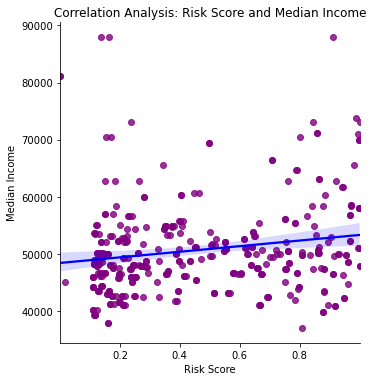

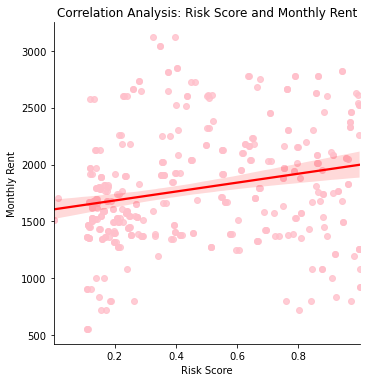

In [72]:
#Correlation analysis

import seaborn as sns
import scipy

#Correlation Analysis: Risk-Score and Median-Income
res1 = pd.read_sql_query("SELECT * FROM risk_score", conn)
corr, pvalue = scipy.stats.pearsonr(res1['final_risk_score'], res1['median_income'])

print("Correlation value for Risk Score and Median Income: " + str(corr))
print("p-value for Risk Score and Median Income: " + str(pvalue))

sns.lmplot(x='final_risk_score',y='median_income',data=res1,fit_reg=True, line_kws={'color':'blue'}, scatter_kws={'color':'purple'}) 
plt.xlabel("Risk Score")
plt.ylabel("Median Income")
plt.title("Correlation Analysis: Risk Score and Median Income")

#Correlation Analysis: Risk-Score and Monthly-Rental
res2 = pd.read_sql_query("SELECT * FROM risk_score", conn)
corr, pvalue = scipy.stats.pearsonr(res2['final_risk_score'], res2['avg_monthly_rent'])

print("Correlation value for Risk Score and Monthly Rent: " + str(corr))
print("p-value for Risk Score and Monthly Rent: " + str(pvalue))

sns.lmplot(x='final_risk_score',y='avg_monthly_rent',data=res2,fit_reg=True, line_kws={'color':'red'}, scatter_kws={'color':'pink'}) 
plt.xlabel("Risk Score")
plt.ylabel("Monthly Rent")
plt.title("Correlation Analysis: Risk Score and Monthly Rent")



Correlation value for Risk Score and Dwelling Density: 0.6847206333185539
Correlation value for Risk Score and Population Density: 0.7940386451615802


Text(0.5, 1.0, 'Population Density VS Fire Risk Score')

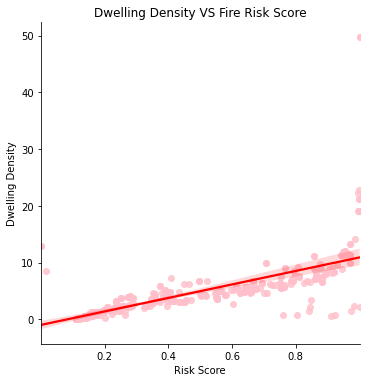

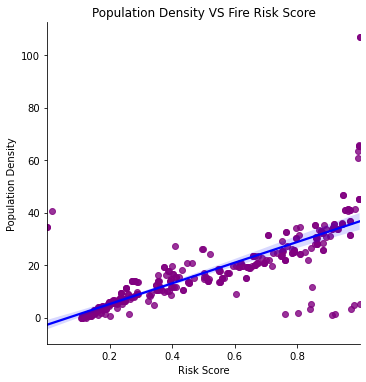

In [67]:
# Analysisng different trends.

import seaborn as sns

# Dwelling Density VS Fire Risk Score

#Correlation Analysis
res1 = pd.read_sql_query("SELECT * FROM risk_score", conn)
cor1 = res1['final_risk_score'].corr(res1['dwel_density'], method='pearson')
print("Correlation value for Risk Score and Dwelling Density: " + str(cor1))

sns.lmplot(x='final_risk_score',y='dwel_density',data=res1,fit_reg=True, line_kws={'color':'red'}, scatter_kws={'color':'pink'}) 
plt.xlabel("Risk Score")
plt.ylabel("Dwelling Density")
plt.title("Dwelling Density VS Fire Risk Score")

# Population Density VS Fire Risk Score

#Correlation Analysis
res1 = pd.read_sql_query("SELECT * FROM risk_score", conn)
cor1 = res1['final_risk_score'].corr(res1['pop_density'], method='pearson')
print("Correlation value for Risk Score and Population Density: " + str(cor1))


sns.lmplot(x='final_risk_score',y='pop_density',data=res1,fit_reg=True, line_kws={'color':'blue'}, scatter_kws={'color':'purple'}) 
plt.xlabel("Risk Score")
plt.ylabel("Population Density")
plt.title("Population Density VS Fire Risk Score")


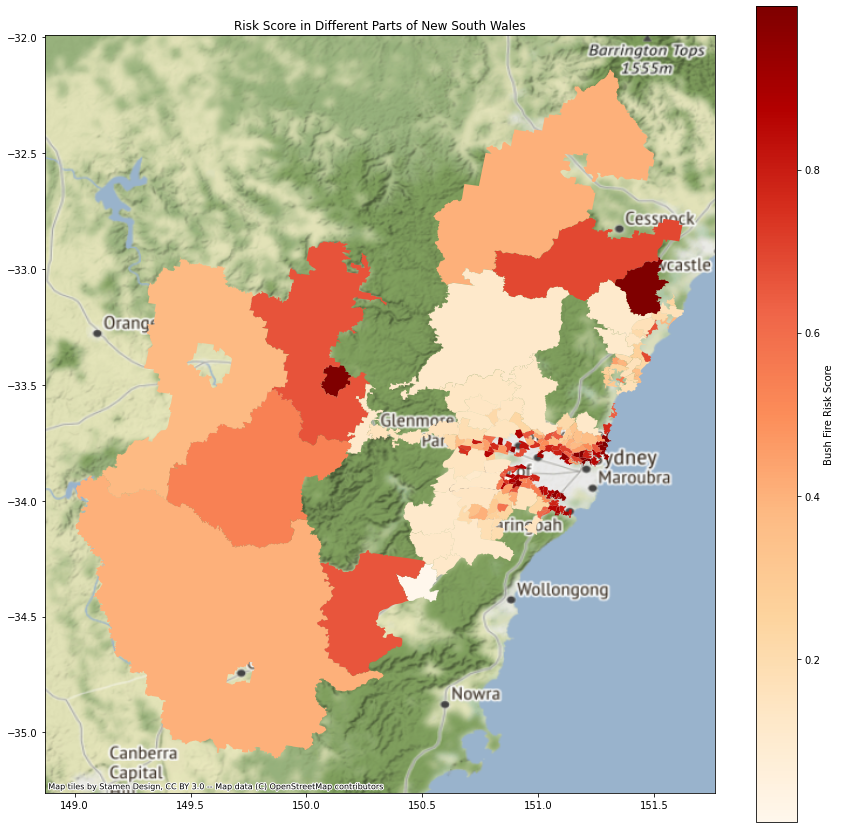

In [12]:
# Visualising the risk scores on a map.
import contextily as cx

def convert_multipolygon(geom):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
        return geom

res = pd.read_sql_query("SELECT sa2_main16, final_risk_score FROM risk_score", conn)
risk_score = res['final_risk_score']
sql_sa2 = res['sa2_main16']

res1 = aust_rows.copy()
existing_sa2 = res1['sa2_main16']

res1['geometry'] = aust_rows['geometry'].apply(lambda x: convert_multipolygon(geom=x))

ls = []
count= 0
s = 0
n =0

# Finding the list of multipolygons which correspond to the particular row in the risk_score table
for i in existing_sa2: 
    for j in sql_sa2: 
        count+=1 
        
        if int(i) == int(j):
            s += risk_score[count - 1]
            n += 1
            
    if n == 0:
        ls.append(0)
    else:
        ls.append(s/n)
    s = 0
    n = 0
    count = 0
    
# Adding the multipolygon to the data frame.
res1.insert(loc=0, column='risk_score', value=ls)

# Value 0.0 indicates that the neighbourhood is not in New South Wales.
val = res1[res1['risk_score'] == 0.0].index
res1.drop(val, inplace=True)

# Plotting the map.
res1.crs
df_wm = res1.to_crs(epsg=4283)
ax = df_wm.plot(column='risk_score', cmap='OrRd', legend=True, alpha = 1, figsize=(15, 15), legend_kwds={"label":"Bush Fire Risk Score"})
plt.title("Risk Score in Different Parts of New South Wales")
cx.add_basemap(ax, crs=res1.crs)


In [83]:
#Closing connection
conn.close()
db.dispose()